# Book Recommendation Experiment

To directly download datasets from Kaggle in the notebook, follow the instructions [here](https://towardsdatascience.com/downloading-datasets-from-kaggle-for-your-ml-project-b9120d405ea4). You will need to define the `KAGGLE_USERNAME` and `KAGGLE_KEY` environment variables.

In [245]:
# !pip install opendatasets  # To download datasets directly from kaggle
# !pip install pandarallel
# !pip install fasttext  # for detecting the language in which texts are written. version '0.9.2'
# !pip install transformers==4.22.2  # for embedding texts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 7.6 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 7.8 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.5/163.5 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.9/293.9 kB 3.4 MB/s eta 0:00:0000:0100:01


In [1]:
import os
from typing import Optional, List, Dict, Any, Tuple, Union

import fasttext
import numpy as np
import opendatasets as od
import pandas as pd
import requests
import torch
from pandarallel import pandarallel
from tqdm import trange
from transformers import AutoTokenizer, AutoModel, AutoConfig

In [75]:
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [9]:
od.download("https://www.kaggle.com/datasets/bahramjannesarr/goodreads-book-datasets-10m/download?datasetVersionNumber=18")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:Your Kaggle Key:Downloading goodreads-book-datasets-10m.zip to ./goodreads-book-datasets-10m


100%|██████████| 460M/460M [01:02<00:00, 7.75MB/s] 


## Load all books

In [156]:
book_files = [f for f in os.listdir("goodreads-book-datasets-10m") if f.startswith("book")]
book_files = sorted(book_files)
book_df = pd.concat(
    [pd.read_csv(os.path.join("goodreads-book-datasets-10m", f)) for f in book_files],
    ignore_index=True
)
len(book_df)

1850310

In [157]:
book_df.head()

,Id,Name,RatingDist1,pagesNumber,RatingDist4,RatingDistTotal,PublishMonth,PublishDay,Publisher,CountsOfReview,...,Language,Authors,Rating,RatingDist2,RatingDist5,ISBN,RatingDist3,Description,Count of text reviews,PagesNumber
0,1,Harry Potter and the Half-Blood Prince (Harry ...,1:9896,652.0,4:556485,total:2298124,16,9,Scholastic Inc.,28062,...,eng,J.K. Rowling,4.57,2:25317,5:1546466,NaN,3:159960,NaN,NaN,NaN
1,2,Harry Potter and the Order of the Phoenix (Har...,1:12455,870.0,4:604283,total:2358637,1,9,Scholastic Inc.,29770,...,eng,J.K. Rowling,4.50,2:37005,5:1493113,0439358078,3:211781,NaN,NaN,NaN
2,3,Harry Potter and the Sorcerer's Stone (Harry P...,1:108202,309.0,4:1513191,total:6587388,1,11,Scholastic Inc,75911,...,eng,J.K. Rowling,4.47,2:130310,5:4268227,NaN,3:567458,NaN,NaN,NaN
3,4,Harry Potter and the Chamber of Secrets (Harry...,1:11896,352.0,4:706082,total:2560657,1,11,Scholastic,244,...,eng,J.K. Rowling,4.42,2:49353,5:1504505,0439554896,3:288821,NaN,NaN,NaN
4,5,Harry Potter and the Prisoner of Azkaban (Harr...,1:10128,435.0,4:630534,total:2610317,1,5,Scholastic Inc.,37093,...,eng,J.K. Rowling,4.57,2:24849,5:1749958,043965548X,3:194848,NaN,NaN,NaN


In [165]:
book_df.isna().sum()

Id                             0
Name                           0
RatingDist1                    0
pagesNumber              1015232
RatingDist4                    0
RatingDistTotal                0
PublishMonth                   0
PublishDay                     0
Publisher                  17826
CountsOfReview                 0
PublishYear                    0
Language                 1598488
Authors                        0
Rating                         0
RatingDist2                    0
RatingDist5                    0
ISBN                        5923
RatingDist3                    0
Description               679122
Count of text reviews    1440613
PagesNumber               835078
dtype: int64

### Select relevant columns

In [167]:
# Convert Ratings from str to int
for i in range(1, 6):
    book_df[f"NumRating{i}"] = book_df[f"RatingDist{i}"].apply(lambda s: int(s[2:]))

# Total number of ratings
book_df["NumRatings"] = book_df["NumRating1"] + book_df["NumRating2"] + book_df["NumRating3"] + book_df["NumRating4"] + book_df["NumRating5"]

# Quality Check: Make sure the column `Rating` is the average of all ratings
def _avg(rating_1: int, rating_2: int, rating_3: int, rating_4: int, rating_5: int) -> float:
    denom = rating_1 + rating_2 + rating_3 + rating_4 + rating_5
    if denom == 0:
        return 0.0
    else:
        return (rating_1 + 2*rating_2 + 3 * rating_3 + 4 * rating_4 + 5 * rating_5) / denom


diff = book_df.parallel_apply(
    lambda row: abs(_avg(row["NumRating1"], row["NumRating2"], row["NumRating3"], row["NumRating4"], row["NumRating5"]) - row["Rating"]) < 0.01,
    axis=1
)
assert diff.all()

In [169]:
# Drop irrelevant columns
cols_to_drop = ["RatingDist1", "RatingDist2", "RatingDist3", "RatingDist4", "RatingDist5", "RatingDistTotal"]
book_df.drop(cols_to_drop, axis=1, inplace=True)

In [170]:
book_df.head()

,Id,Name,pagesNumber,PublishMonth,PublishDay,Publisher,CountsOfReview,PublishYear,Language,Authors,...,ISBN,Description,Count of text reviews,PagesNumber,NumRating1,NumRating2,NumRating3,NumRating4,NumRating5,NumRatings
0,1,Harry Potter and the Half-Blood Prince (Harry ...,652.0,16,9,Scholastic Inc.,28062,2006,eng,J.K. Rowling,...,NaN,NaN,NaN,NaN,9896,25317,159960,556485,1546466,2298124
1,2,Harry Potter and the Order of the Phoenix (Har...,870.0,1,9,Scholastic Inc.,29770,2004,eng,J.K. Rowling,...,0439358078,NaN,NaN,NaN,12455,37005,211781,604283,1493113,2358637
2,3,Harry Potter and the Sorcerer's Stone (Harry P...,309.0,1,11,Scholastic Inc,75911,2003,eng,J.K. Rowling,...,NaN,NaN,NaN,NaN,108202,130310,567458,1513191,4268227,6587388
3,4,Harry Potter and the Chamber of Secrets (Harry...,352.0,1,11,Scholastic,244,2003,eng,J.K. Rowling,...,0439554896,NaN,NaN,NaN,11896,49353,288821,706082,1504505,2560657
4,5,Harry Potter and the Prisoner of Azkaban (Harr...,435.0,1,5,Scholastic Inc.,37093,2004,eng,J.K. Rowling,...,043965548X,NaN,NaN,NaN,10128,24849,194848,630534,1749958,2610317


### Aggregate books that appear more than once

In [183]:
counts_df = book_df.groupby(["Name", "Authors"], as_index=False).size()
counts_df.sort_values("size", ascending=False)

,Name,Authors,size
698344,Jane Eyre,Charlotte Brontë,21
1472509,The Scarlet Letter,Nathaniel Hawthorne,21
812602,Madame Bovary,Gustave Flaubert,20
826394,Mansfield Park,Jane Austen,20
576098,Hamlet,William Shakespeare,20
...,...,...,...
583866,Harmony and Counterpoint: Ritual Music in Chin...,Bell Yung,1
583865,Harmony and Conflict in the Living World,Alexander F. Skutch,1
583864,Harmony and Composition: Basics to Intermediate,Deborah Jamini,1
583863,Harmony Through Melody: The Interaction of Mel...,Charles Horton,1


In [195]:
def agg_book_info(_df: pd.DataFrame) -> pd.Series:
    # Rating
    num_rating_1 = _df["NumRating1"].sum()
    num_rating_2 = _df["NumRating2"].sum()
    num_rating_3 = _df["NumRating3"].sum()
    num_rating_4 = _df["NumRating4"].sum()
    num_rating_5 = _df["NumRating5"].sum()
    num = num_rating_1 + 2 * num_rating_2 + 3 * num_rating_3 + 4 * num_rating_4 + 5 * num_rating_5
    denom = num_rating_1 + num_rating_2 + num_rating_3 + num_rating_4 + num_rating_5
    rating = 0.0 if denom == 0 else num / denom
    # Description
    non_empty_desc_df = _df[_df["Description"].notna()].copy()
    description = non_empty_desc_df.sort_values("NumRatings", ascending=False).iloc[0]["Description"] if len(non_empty_desc_df) > 0 else None

    return pd.Series(
        {
            "NumRating1": num_rating_1, "NumRating2": num_rating_2, "NumRating3": num_rating_3,
            "NumRating4": num_rating_4, "NumRating5": num_rating_5, "NumRatings": denom,
            "Rating": rating, "Description": description
        },
        index=["NumRating1", "NumRating2", "NumRating3", "NumRating4", "NumRating5", "NumRatings", "Rating", "Description"]
    )


book_group_df = book_df.groupby(["Name", "Authors"], as_index=False).apply(agg_book_info)

In [196]:
book_group_df[(book_group_df["Name"] == "A Christmas Carol") & (book_group_df["Authors"] == "Charles Dickens")]

,Name,Authors,NumRating1,NumRating2,NumRating3,NumRating4,NumRating5,NumRatings,Rating,Description
17320,A Christmas Carol,Charles Dickens,166716.0,485710.0,2108642.0,3618018.0,4154460.0,10533546.0,4.054516,"From the bustling, snowy streets of nineteenth..."


In [199]:
book_group_df.head()

,Name,Authors,NumRating1,NumRating2,NumRating3,NumRating4,NumRating5,NumRatings,Rating,Description
0,!%@: A Directory of Electronic Mail Addressing...,Donnalyn Frey,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,!%@:: A Directory of Electronic Mail Addressin...,Rick Adams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"These days, it's a rare person who hasn't hear..."
2,!Adelante!: A Cultural Approach to Intermediat...,Eduardo Neale-Silva,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,!Arrebátalo!: La fe que se mantiene firme ante...,Judy Jacobs,0.0,0.0,0.0,2.0,0.0,2.0,4.0,<i>¡Aprende a caminar en el poder de la fe vio...
4,"!Buen viaje!, Course 1, Student Edition",McGraw-Hill Education,1.0,1.0,2.0,0.0,1.0,5.0,2.8,This three-level program brings you every reso...


In [198]:
book_group_df.to_pickle("goodreads-book-datasets-10m/books_processed.json")

In [202]:
del book_df # Save disk space
book_df = book_group_df.copy()
del book_group_df # Save disk space

### How many books have a description?


65% of the books (~1.1M books) have a non-empty description, which is enough data to try to train a simple text model that computes the similarity between books based on their:
- Title
- Author, maybe?
- Description

In [237]:
def is_str_non_empty(s):
    if s is None or not isinstance(s, str):
        return False
    return len(s) > 0


mask_non_empty_description = book_df["Description"].apply(is_str_non_empty)
print(f"Number of books with a (non-empty) description: {mask_non_empty_description.sum()} (~{mask_non_empty_description.sum() / len(book_df):.0%})")

Number of books with a (non-empty) description: 1091680 (~65%)


### Language Distribution of book titles and description

Knowing the language of the books/descriptions will help us decide what model is better for embedding the texts:
- a monolingual English model like BERT;
- or a multilingual model like XLM-RoBERTa.

In [213]:
# Download fastText language detection model to `models`
!curl -fLS https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin -o ../models/lid.176.bin

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  125M  100  125M    0     0  9725k      0  0:00:13  0:00:13 --:--:-- 11.1M    0  0:00:17  0:00:05  0:00:12 8896k


In [234]:
# Ignore warning https://github.com/facebookresearch/fastText/issues/1067
fasttext.FastText.eprint = lambda x: None

class LanguageDetector:
    def __init__(self):
        self.language_model = fasttext.load_model("../models/lid.176.bin")

    @staticmethod
    def _process_input(text: str) -> str:
        return text.replace("\n", "")

    @staticmethod
    def _process_output(output: Tuple[Tuple[str], np.ndarray]) -> str:
        return output[0][0][9:]

    def predict_language(self, text: str) -> str:
        """Predicts the language in which the input text is written"""
        if text is None or not isinstance(text, str):
            return None
        prediction = self.language_model.predict(self._process_input(text))
        return self._process_output(prediction)

In [236]:
lang_model = LanguageDetector()
for col in ["Name", "Description"]:
    book_df[f"{col}Lang"] = book_df[col].parallel_apply(lambda s: lang_model.predict_language(s))

In [241]:
book_df["DescriptionLang"].value_counts(normalize=True)

en    9.537264e-01
de    2.036128e-02
fr    1.196962e-02
es    8.064634e-03
it    1.332808e-03
          ...     
sw    9.160193e-07
tl    9.160193e-07
nn    9.160193e-07
yi    9.160193e-07
ur    9.160193e-07
Name: DescriptionLang, Length: 70, dtype: float64

In [242]:
book_df["NameLang"].value_counts(normalize=True)

en     9.175285e-01
de     2.837329e-02
fr     2.151374e-02
es     1.576222e-02
it     4.301801e-03
           ...     
ht     5.922083e-07
my     5.922083e-07
hsb    5.922083e-07
ne     5.922083e-07
wuu    5.922083e-07
Name: NameLang, Length: 119, dtype: float64

### Embed text representation of books

In [347]:
def concatenate_texts(texts: List[str], separator: str = "</s>") -> str:
    cleaned_texts = [t if t is not None else "" for t in texts]
    return separator.join(cleaned_texts)


book_description_df = book_df[mask_non_empty_description].copy()
book_description_df["BookRepresentation"] = book_description_df.parallel_apply(
    lambda row: concatenate_texts([row["Name"], row["Authors"], row["Description"]]),
    axis=1
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [353]:
book_description_df = book_description_df.sample(1000, random_state=123)

In [354]:
book_description_df.sample(1).iloc[0]["BookRepresentation"]

'The Highly Effective Detective (The Highly Effective Detective, #1)</s>Rick Yancey</s>Meet Teddy Ruzak. After his mother dies, Teddy quits his job as a night watchman to fulfill his childhood dream of being a detective. With little planning and even less foresight, he hangs up his shingle and hires his favorite waitress from the local diner to be his Girl Friday.<br /><br />\xa0<br /><br />And his first case? Bringing to justice the thoughtless driver who mows down six baby geese. Not the most exciting assignment—until Teddy’s “wild-goose chase” quickly evolves into an investigation of a vicious murder.'

In [3]:
class TextSimilarityModel:
    def __init__(self, model_name: str):
        config = AutoConfig.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(
            model_name, config=config
        )
        self.model.eval()
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)


    def encode(self,
        texts: Union[str, List[str]],
        batch_size: int = 32,
        max_length: int = 128,
        normalize_embeddings: bool = False,
    ) -> torch.Tensor:
        """
        Returns the [CLS] token embedding of shape [num_texts, hidden_size]
        Highly inspired by sentence-transformers:
        https://github.com/UKPLab/sentence-transformers/blob/a8cebb235066cacf533d073b8c8250e5e7b04c3d/sentence_transformers/SentenceTransformer.py#L111-L202
        """
        if isinstance(texts, str):
            texts = [texts]

        embeds = []
        length_sorted_idx = np.argsort([-len(text) for text in texts])
        texts_sorted = [texts[idx] for idx in length_sorted_idx]

        for start_index in trange(0, len(texts), batch_size, desc="Batches"):
            tokens = self.tokenizer(
                texts_sorted[start_index:start_index + batch_size],
                max_length=max_length,
                padding=True,
                truncation=True,
                return_tensors="pt",
                return_attention_mask=True
            )
            output = self.model(**tokens)
            embed = output.pooler_output
            if normalize_embeddings:
                embed = torch.nn.functional.normalize(embed, p=2, dim=1)
            embeds.extend(embed)

        # Sort outputs according to original order
        embeds = [embeds[idx] for idx in np.argsort(length_sorted_idx)]
        # Convert output to tensor of shape (num_texts, hidden_size)
        return torch.stack(embeds)

    @staticmethod
    def dot_product(x: torch.Tensor, encodings: torch.Tensor) -> torch.Tensor:
        """
        Computes the dot product between x, a tensor of shape [1, d], and every of
        the n elements of `encodings`, a tensor of shape [n, d].
        The output will be a tensor of shape [1, n].
        """
        return torch.mm(x, torch.transpose(encodings, 0, 1))

    def top_k_most_similar_items(self, x: torch.Tensor, encodings: torch.Tensor, top_k: int) -> List[Tuple[int, float]]:
        """Returns the top k most similar items in `encodings` to `x`.

        Args
            x:
                tensor of shape [1, d] containing the embedding of the item to find the top k closest ones;
            encodings:
                tensor of shape [n, d] containing the embeddings of the items that `x` will be compared to.

        Returns
            a list containing the top k most similar items, sorted by similarity in ascending order (closest first).
            The i-th element of the list is a tuple containing the index of the item that is ranked in i-th place and
            the corresponding similarity (dot product).
        """
        similarity = self.dot_product(x, encodings)
        idx_sorted = torch.argsort(similarity, descending=True)
        idx_top_k = idx_sorted[:top_k]
        top_k_list = []

        for idx in idx_top_k:
            idx = idx.item()
            top_k_list.append((idx, similarity[idx].item()))

        return top_k_list

In [ ]:
text_sim = TextSimilarityModel("xlm-roberta-base")
encodings = text_sim.encode(book_description_df["BookRepresentation"].tolist(), batch_size=32, normalize_embeddings=True)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Batches:  16%|█▌        | 5/32 [01:03<05:50, 12.98s/it]

In [5]:
sample = book_df[mask_non_empty_description].sample(1).iloc[0]
x = concatenate_texts([sample["Name"], sample["Authors"], sample["Description"]])
x

NameError: name 'book_df' is not defined

In [342]:
x_encoding = text_sim.encode(x, normalize_embeddings=True)

Batches: 100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


In [4]:
x_encoding

NameError: name 'x_encoding' is not defined

In [344]:
torch.argmax(sim)

tensor(19)

In [345]:
_df.iloc[19]["TextRepresentation"]

'Business and Technical Communication: An Annotated Guide to Sources, Skills, and Samples</s>Sandra E. Belanger</s>The amount of material published in business and technical communications is still growing despite the number of textbooks, guides, and other resources that have already appeared. Universities continue to stress communication skills in business and engineering, partly in response to concerns expressed by executives and managers. What students and practitioners require for skill improvement are clear guidelines, well-structured outlines, and pertinent examples. This work locates these essential materials and the research tools needed to unlock them.<br /><br /><br /><br />This handbook couples research sources, an annotated bibliography of how-to information, and detailed indexes to identify the most relevant items in aiding business and technical communication. Organized in two sections, the first consists of a research handbook, consisting of tools (i.e., dictionaries), r

## Load all user ratings

In [115]:
user_rating_files = [f for f in os.listdir("goodreads-book-datasets-10m") if f.startswith("user_rating_")]
user_rating_files = sorted(user_rating_files)
user_df = pd.concat(
    [pd.read_csv(os.path.join("goodreads-book-datasets-10m", f)) for f in user_rating_files],
    ignore_index=True
)
len(user_df)

362596

In [116]:
user_df.head()

,ID,Name,Rating
0,1,Agile Web Development with Rails: A Pragmatic ...,it was amazing
1,1,The Restaurant at the End of the Universe (Hit...,it was amazing
2,1,Siddhartha,it was amazing
3,1,The Clock of the Long Now: Time and Responsibi...,really liked it
4,1,"Ready Player One (Ready Player One, #1)",really liked it


In [133]:
user_df["Rating"].value_counts()

really liked it                      132808
liked it                              96047
it was amazing                        92354
it was ok                             28811
did not like it                        7811
This user doesn't have any rating      4765
Name: Rating, dtype: int64

In [138]:
# Map rating string to int
rating_str2int = {
    "did not like it": 1,
    "it was ok": 2,
    "liked it": 3,
    "really liked it": 4,
    "it was amazing": 5,
}
user_df.rename(columns={"Rating": "RatingStr"}, inplace=True)
user_df["Rating"] = user_df["RatingStr"].map(rating_str2int)

In [140]:
# Drop users that don't have any ratings
n = len(user_df)
user_df = user_df[user_df["Rating"].notna()].copy()
print(f"Dropped {n - len(user_df)} ({(n - len(user_df)) / n:.0%}) ratings that were empty")

Dropped 4765 (1%) ratings that were empty


In [141]:
print(f"Total number of users: {user_df['ID'].nunique()}")

Total number of users: 4154


In [144]:
user_rating_counts_df = user_df.groupby("ID", as_index=False).size()
user_rating_counts_df.sort_values("size", ascending=False)

,ID,size
1779,4196,3637
2041,4806,3236
1991,4693,2736
590,1134,2089
158,284,2052
...,...,...
651,1252,1
650,1250,1
3130,8362,1
642,1226,1


<AxesSubplot: >

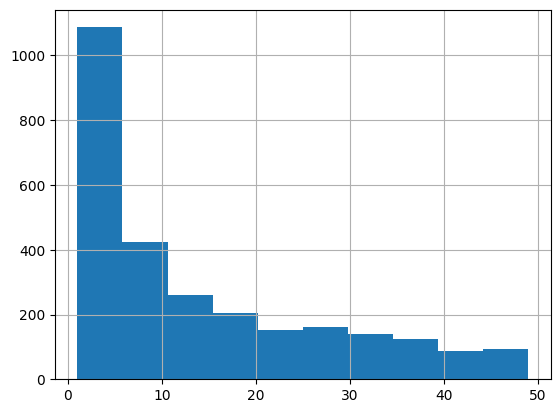

In [155]:
user_rating_counts_df[user_rating_counts_df["size"] < 50]["size"].hist()

In [149]:
# 35% of the users have given less than 10 ratings
(user_rating_counts_df["size"] < 10).sum() / len(user_rating_counts_df)

0.3468945594607607

In [153]:
# 88% of the users have given at least 2 ratings
# 77% of the users have given at least 5 ratings
(user_rating_counts_df["size"] >= 5).sum() / len(user_rating_counts_df)

0.7650457390467019

## Step 1: Get the book's description and categories from Google Books API

Can't do it because of limitations of Google Books API 😢 (see [here](https://developers.google.com/analytics/devguides/config/mgmt/v3/limits-quotas)).

In [90]:
class GoogleBooksAPI:
    def __init__(self, book_query: str) -> None:
        self._book_query = book_query
        url = f"https://www.googleapis.com/books/v1/volumes?q={book_query}"
        r = requests.get(url)
        data = r.json()
        if data is None or data.get("items") is None or len(data.get("items")) == 0 or data["items"][0].get("volumeInfo") is None:
            raise ValueError(f"No book found with query: '{book_query}'!")
        self.book_info = data["items"][0]["volumeInfo"]

    @property
    def book_query(self):
        return self._book_query

    @property
    def title(self) -> Optional[str]:
        """The title of the book, if it exists"""
        if title := self.book_info.get("title"):
            if subtitle := self.book_info.get("subtitle"):
                title += f": {subtitle}"
            return title
        else:
            return None

    @property
    def authors(self) -> Optional[List[str]]:
        """The name of the authors of the book"""
        return self.book_info.get("authors")

    @property
    def description(self) -> Optional[str]:
        """A description of the book, if one exists"""
        return self.book_info.get("description")

    @property
    def publisher(self) -> Optional[str]:
        """A publisher of the book"""
        return self.book_info.get("publisher")

    @property
    def date(self) -> Optional[str]:
        """The date in which the book was published"""
        return self.book_info.get("publishedDate")

    @property
    def categories(self) -> Optional[List[str]]:
        """The categories of the book, i.e. tags about the content of the book"""
        return self.book_info.get("categories")

    @property
    def image(self) -> Optional[str]:
        """An URL containing an image of the book, if one exists"""
        images = self.book_info.get("imageLinks")
        if isinstance(images, dict):
            return images.get("thumbnail")
        return None


def get_book_info(book_query: str) -> Dict[str, Any]:
    book = GoogleBooksAPI(book_query)
    return {
        "title": book.title,
        "description": book.description,
        "categories": book.categories,
        "image_url": book.image,
    }

In [79]:
sample_book = df.sample(1).iloc[0]
google_book = GoogleBooksAPI(sample_book["Name"])
print(
    f"""
    Query: {google_book.book_query}
    Title: {google_book.title}
    Authors: {google_book.authors} ({sample_book['Authors']})
    Description: {google_book.description}
    Date: {google_book.date} ({sample_book['PublishYear']})
    Publisher: {google_book.publisher} ({sample_book['Publisher']})
    Tags: {google_book.categories}
    """
)


    Query: The Hidden Persuaders
    Title: The Hidden Persuaders
    Authors: ['Vance Packard', 'Vance Oakley Packard'] (Vance Packard)
    Description: The first book to expose how advertising and media attempts to control our thoughts and desires.
    Date: 1981 (2007)
    Publisher: None (Pocket Books)
    Tags: ['Advertising']
    


In [83]:
df["BookInfo"] = df["Name"].parallel_apply(get_book_info)

/Users/ines.pedro/Code/full-stack-deep-learning/deep-tsundoku/venv/lib/python3.9/site-packages/pandarallel/data_types/series.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  yield data[chunk_]


In [85]:
for key, col in {"title": "Title", "description": "Description", "categories": "Categories", "image_url": "ImageURL"}.items():
    df[col] = df["BookInfo"].apply(lambda d: d.get(key))

In [87]:
df.sample(5)

,Id,Name,RatingDist1,pagesNumber,RatingDist4,RatingDistTotal,PublishMonth,PublishDay,Publisher,CountsOfReview,...,NumRating2,NumRating3,NumRating4,NumRating5,NumRatings,BookInfo,Title,Description,Categories,ImageURL
36780,62408,Aléxandros: Las arenas de Amón,1:30,341,4:2037,total:5194,28,1,Mondadori (IT),0,...,182,950,2037,1995,5194,{},None,None,None,None
21532,35885,Flashback,1:4,407,4:27,total:101,1,10,Avon Books,9,...,7,34,27,29,101,{},None,None,None,None
26262,43714,Instructor's Manual t/a Structure and Interpre...,1:0,224,4:10,total:33,15,9,MIT Press (MA),1,...,2,3,10,18,33,{},None,None,None,None
23947,39800,A Bridge to the Stars,1:47,160,4:316,total:1050,1,9,Andersen,2,...,133,345,316,209,1050,"{'title': 'A Bridge to the Stars', 'descriptio...",A Bridge to the Stars,12 year old Joel lives with his father in the ...,[Juvenile Fiction],http://books.google.com/books/content?id=Cwvja...
38848,66433,Harriet Jacobs and Incidents in the Life of a ...,1:0,320,4:11,total:32,18,4,Cambridge University Press,6,...,0,9,11,12,32,{},None,None,None,None


In [95]:
url = f"https://www.googleapis.com/books/v1/volumes?q=Aléxandros: Las arenas de Amón"
r = requests.get(url)
data = r.json()
# if data is None or data.get("items") is None or len(data.get("items")) == 0 or data["items"][0].get("volumeInfo") is None:
#     raise ValueError(f"No book found with query: '{book_query}'!")
# self.book_info = data["items"][0]["volumeInfo"]

In [96]:
data

{'error': {'code': 429,
  'message': "Quota exceeded for quota metric 'Queries' and limit 'Queries per minute per user' of service 'books.googleapis.com' for consumer 'project_number:624717413613'.",
  'errors': [{'message': "Quota exceeded for quota metric 'Queries' and limit 'Queries per minute per user' of service 'books.googleapis.com' for consumer 'project_number:624717413613'.",
    'domain': 'global',
    'reason': 'rateLimitExceeded'}],
  'status': 'RESOURCE_EXHAUSTED',
  'details': [{'@type': 'type.googleapis.com/google.rpc.ErrorInfo',
    'reason': 'RATE_LIMIT_EXCEEDED',
    'domain': 'googleapis.com',
    'metadata': {'service': 'books.googleapis.com',
     'quota_limit_value': '100',
     'quota_location': 'global',
     'quota_metric': 'books.googleapis.com/default',
     'quota_limit': 'defaultPerMinutePerUser',
     'consumer': 'projects/624717413613'}},
   {'@type': 'type.googleapis.com/google.rpc.Help',
    'links': [{'description': 'Request a higher quota limit.',
   

In [94]:
_book = GoogleBooksAPI("Aléxandros: Las arenas de Amón")
_book.book_info

ValueError: No book found with query: 'Aléxandros: Las arenas de Amón'!

In [91]:
get_book_info("Aléxandros: Las arenas de Amón")

ValueError: No book found with query: 'Aléxandros: Las arenas de Amón'!